In [1]:
from dynesty import NestedSampler
from dynesty import plotting as dyplot
from ddm_utils import simulate_ddm, parse_sim_results
from joblib import Parallel, delayed
import pickle
from dynesty_utiils import loglike_fn, prior_transform, _quantile

import matplotlib.pyplot as plt
import numpy as np
from ex23_utils import run_vbmc, save_prior_bounds


# Sim data

In [35]:
N_sim = 5000; v = 0.2; a = 2
sim_results = Parallel(n_jobs=-1)(delayed(simulate_ddm)(v, a) for _ in range(N_sim))


choices, RTs = parse_sim_results(sim_results)
    
with open('sample_rt.pkl', 'wb') as f:
    pickle.dump(RTs, f)
with open('sample_choice.pkl', 'wb') as f:
    pickle.dump(choices, f)

In [36]:
priors_bounds = { 
    'v': [-5,5],
    'a': [1, 3],
    'w': [0.3, 0.7] 
}

with open('dynesty_priors.pkl', 'wb') as f:
    pickle.dump(priors_bounds, f)

In [37]:
import multiprocessing
num_processes = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=num_processes)


In [39]:
ndim = 3
sampler = NestedSampler(loglike_fn, prior_transform, ndim, pool=pool, queue_size=num_processes)
sampler.run_nested()

pool.close()
pool.join()


6979it [05:02, 23.04it/s, +500 | bound: 13 | nc: 1 | ncall: 27712 | eff(%): 27.484 | loglstar:   -inf < -7719.579 <    inf | logz: -7732.753 +/-  0.159 | dlogz:  0.001 >  0.509]


# Last evidence?

In [40]:
sampler.results.logz[-1]

-7732.753137310123

In [7]:
with open(f'dynesty_sampler_N{N_sim}.pkl', 'wb') as f:
    pickle.dump(sampler, f)


In [8]:
nested_samp_results = sampler.results
nested_samp_weights = nested_samp_results.importance_weights()



# Common params for both methods

In [9]:

# Set the limits for each dimension
span = [(-0.2, 0.35), (1.8, 2.2), (0.4, 0.6)]
true_v = 0.2; true_a = 2; true_w = 0.5
save_path = "/home/rka/Pictures"

# Corner plots - Nested Samp

In [10]:
# Set the limits for each dimension

# Initialize figure
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.reshape((3, 3))  # reshape axes

title_kwargs = {'fontsize': 30}  # Increase the title font size
label_kwargs = {'fontsize': 30}  # Increase the label font size
tick_labelsize = 15 

fig, ax = dyplot.cornerplot(nested_samp_results, color='blue', truths=np.array([true_v, true_a, true_w]),
                           truth_color='black', show_titles=True,
                           max_n_ticks=10, labels=['v', 'a', 'w'],
                           fig=(fig, axes[:, :3]), label_kwargs=label_kwargs,
                           title_kwargs=title_kwargs, span=span)

for i in range(3):
    for j in range(3):
        axes[i, j].tick_params(axis='both', which='major', labelsize=tick_labelsize)


import os
os.makedirs(save_path, exist_ok=True)

filename = f"ns_{N_sim}_same_width.png"
full_path = os.path.join(save_path, filename)

# Save the figure
fig.savefig(full_path, dpi=300, bbox_inches='tight')
plt.close(fig)


# Evidence vs iter save

In [11]:
evidence_dict = {'neg_vol': -nested_samp_results.logvol, 
                 'cum_evid': nested_samp_results.logz
                 }
with open(f'ns_{N_sim}_evidence.pkl', 'wb') as f:
    pickle.dump(evidence_dict, f)

# Plots evidence - NS

In [13]:
# ns_5000_evidence.pkl
N_trials_arr = [100, 500, 1000, 5000]
all_evidence_dict = {}
for n in N_trials_arr:
    with open(f'ns_{n}_evidence.pkl', 'rb') as f:
        all_evidence_dict[n] = pickle.load(f)


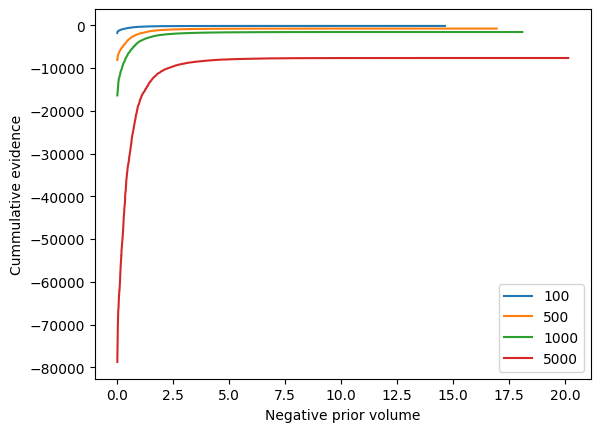

In [17]:
for n in N_trials_arr:
    plt.plot(all_evidence_dict[n]['neg_vol'], all_evidence_dict[n]['cum_evid'])
plt.legend([str(n) for n in N_trials_arr]);
plt.xlabel('Negative prior volume');
plt.ylabel('Cummulative evidence');

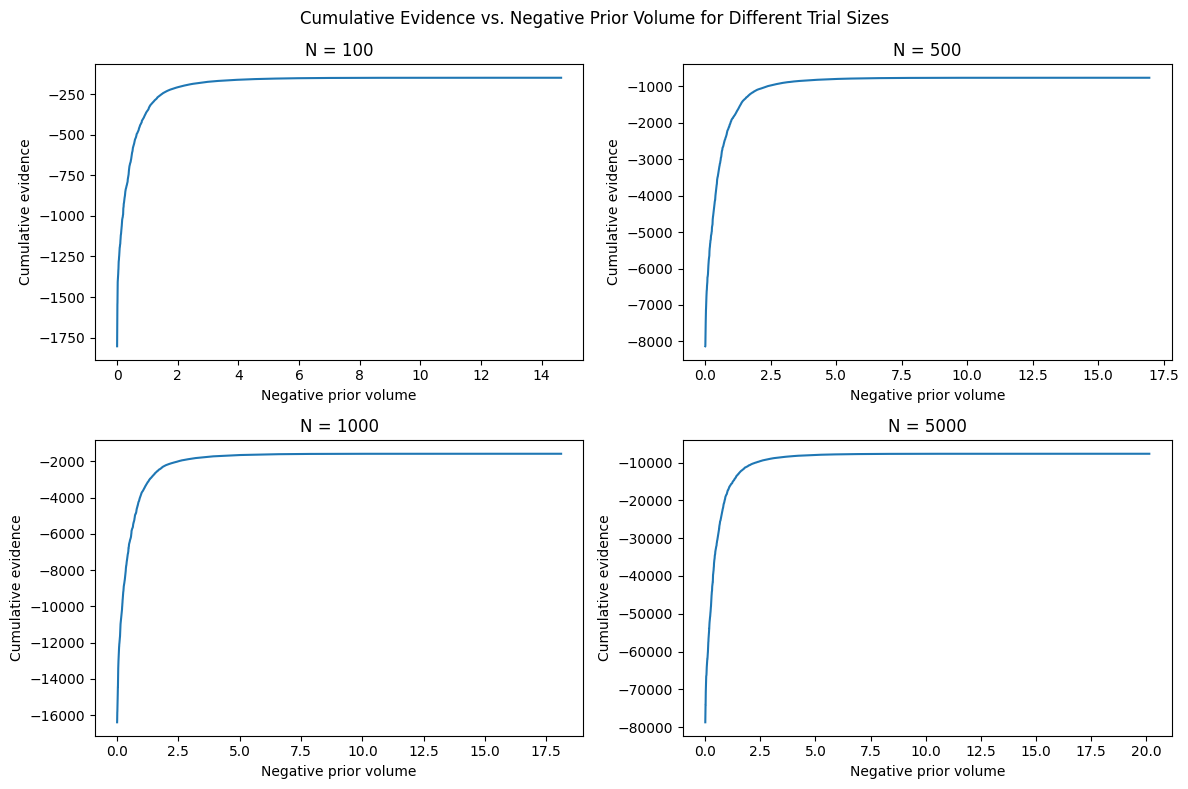

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

N_trials_arr = [100, 500, 1000, 5000]  # Example trial sizes, update with your actual array

# Plot for each trial size in the respective subplot
for i, n in enumerate(N_trials_arr):
    ax = axs[i // 2, i % 2]
    ax.plot(all_evidence_dict[n]['neg_vol'], all_evidence_dict[n]['cum_evid'])
    ax.set_title(f'N = {n}')
    ax.set_xlabel('Negative prior volume')
    ax.set_ylabel('Cumulative evidence')

fig.suptitle('Cumulative Evidence vs. Negative Prior Volume for Different Trial Sizes')
plt.tight_layout()
plt.show()


# Trace plots - NS

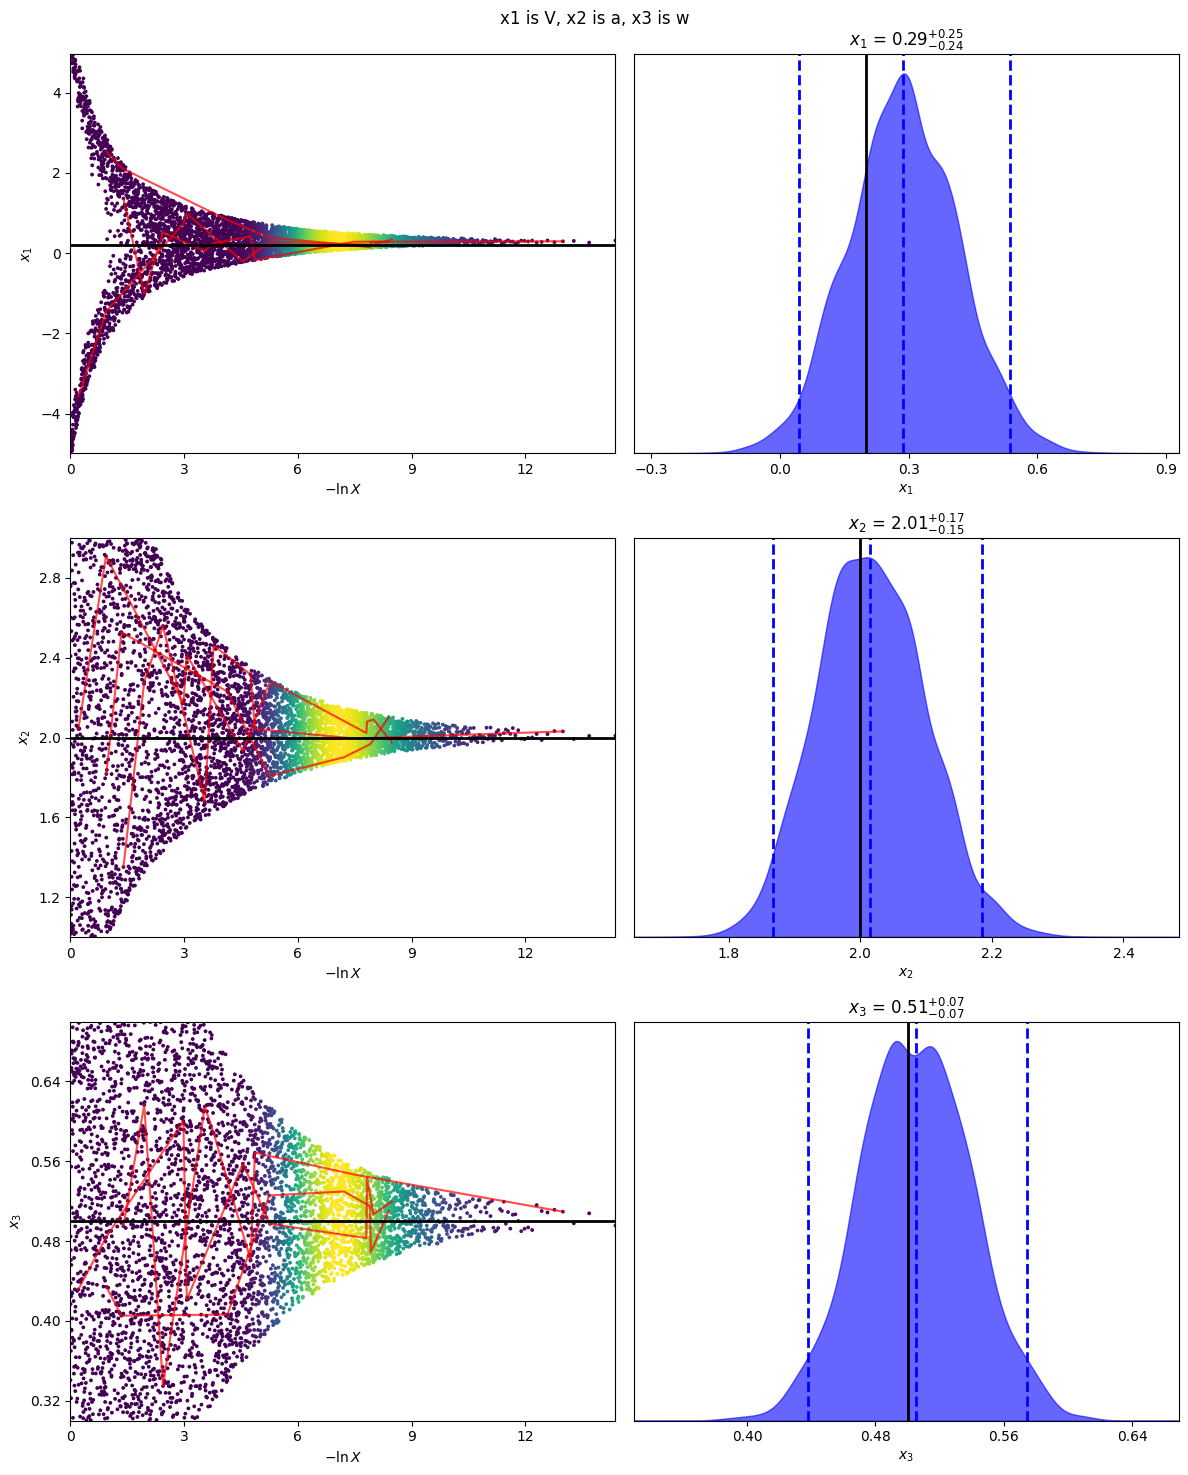

In [54]:
# trace plots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig, axes = dyplot.traceplot(nested_samp_results, truths=np.array([true_v, true_a, true_w]),
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             connect_highlight=range(3), fig=(fig, axes))
fig.suptitle('x1 is V, x2 is a, x3 is w')
plt.tight_layout()

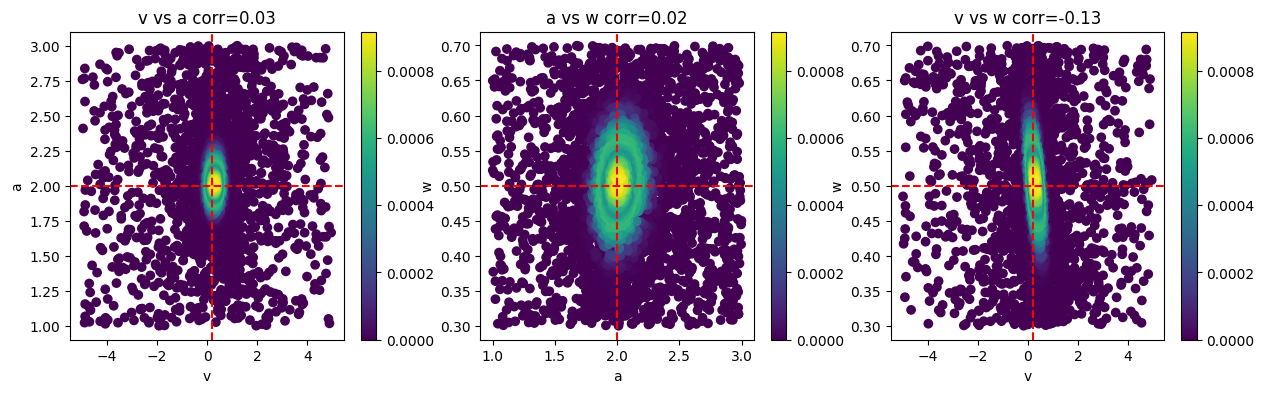

In [55]:
# scatter plots and their range decreased
v_samp = nested_samp_results.samples[:,0]; a_samp = nested_samp_results.samples[:,1]; w_samp = nested_samp_results.samples[:,2]


plt.figure(figsize=(15,4))  
plt.subplot(1,3,1)
sc = plt.scatter(v_samp, a_samp, c=nested_samp_weights, cmap='viridis')
plt.colorbar(sc)
plt.xlabel('v')
plt.ylabel('a')
plt.title(f'v vs a corr={np.corrcoef(v_samp, a_samp)[0,1]:.2f}')
plt.axvline(x=true_v, color='r', linestyle='--')
plt.axhline(y=true_a, color='r', linestyle='--')

# Scatter plot for a vs w
plt.subplot(1,3,2)
sc = plt.scatter(a_samp, w_samp, c=nested_samp_weights, cmap='viridis')
plt.colorbar(sc)
plt.xlabel('a')
plt.ylabel('w')
plt.title(f'a vs w corr={np.corrcoef(a_samp, w_samp)[0,1]:.2f}')
plt.axvline(x=true_a, color='r', linestyle='--')
plt.axhline(y=true_w, color='r', linestyle='--')

# Scatter plot for v vs w
plt.subplot(1,3,3)
sc = plt.scatter(v_samp, w_samp, c=nested_samp_weights, cmap='viridis')
plt.colorbar(sc)
plt.xlabel('v')
plt.ylabel('w')
plt.title(f'v vs w corr={np.corrcoef(v_samp, w_samp)[0,1]:.2f}')
plt.axvline(x=true_v, color='r', linestyle='--')
plt.axhline(y=true_w, color='r', linestyle='--')

plt.show()

In [56]:
v_range = _quantile(v_samp, weights=nested_samp_weights)
a_range = _quantile(a_samp, weights=nested_samp_weights)
w_range = _quantile(w_samp, weights=nested_samp_weights)

In [58]:
v_samp2 = v_samp[(v_samp > v_range[0]) & (v_samp < v_range[1])]
a_samp2 = a_samp[(a_samp > a_range[0]) & (a_samp < a_range[1])]
w_samp2 = w_samp[(w_samp > w_range[0]) & (w_samp < w_range[1])]


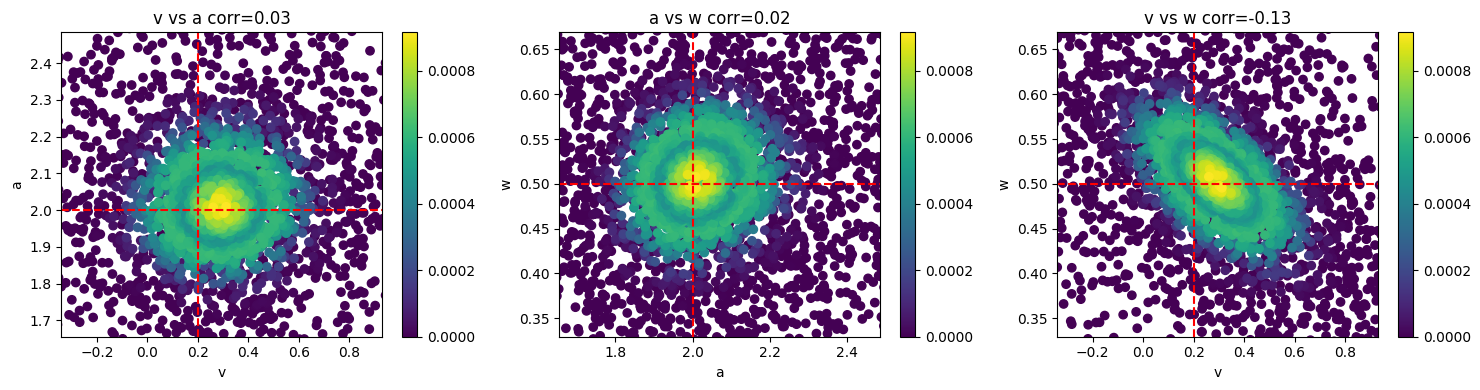

In [59]:

plt.figure(figsize=(15, 4))

# Scatter plot for v vs a
plt.subplot(1, 3, 1)
sc = plt.scatter(v_samp, a_samp, c=nested_samp_weights, cmap='viridis')
plt.colorbar(sc)
plt.xlabel('v')
plt.ylabel('a')
plt.title(f'v vs a corr={np.corrcoef(v_samp, a_samp)[0,1]:.2f}')
plt.axvline(x=true_v, color='r', linestyle='--')
plt.axhline(y=true_a, color='r', linestyle='--')
plt.xlim(v_range)
plt.ylim(a_range)

# Scatter plot for a vs w
plt.subplot(1, 3, 2)
sc = plt.scatter(a_samp, w_samp, c=nested_samp_weights, cmap='viridis')
plt.colorbar(sc)
plt.xlabel('a')
plt.ylabel('w')
plt.title(f'a vs w corr={np.corrcoef(a_samp, w_samp)[0,1]:.2f}')
plt.axvline(x=true_a, color='r', linestyle='--')
plt.axhline(y=true_w, color='r', linestyle='--')
plt.xlim(a_range)
plt.ylim(w_range)

# Scatter plot for v vs w
plt.subplot(1, 3, 3)
sc = plt.scatter(v_samp, w_samp, c=nested_samp_weights, cmap='viridis')
plt.colorbar(sc)
plt.xlabel('v')
plt.ylabel('w')
plt.title(f'v vs w corr={np.corrcoef(v_samp, w_samp)[0,1]:.2f}')
plt.axvline(x=true_v, color='r', linestyle='--')
plt.axhline(y=true_w, color='r', linestyle='--')
plt.xlim(v_range)
plt.ylim(w_range)

plt.tight_layout()
plt.show()

# VBMC

In [41]:
prior_bounds = { 'v_low': -5, 'v_high': 5, 'a_low': 1, 'a_high': 3, 'w_low': 0.3, 'w_high': 0.7 }
save_prior_bounds(prior_bounds)

lb = np.array([-5, 1, 0.3]); ub = np.array([5, 3, 0.7])
plb = np.array([-4.9,1.1,0.31]); pub = np.array([4.9,2.9,0.69])

x0 = np.array([np.random.uniform(plb[0], pub[0]), np.random.uniform(plb[1], pub[1]), np.random.uniform(plb[2], pub[2])])
vp, results = run_vbmc(x0, lb, ub, plb, pub, {'display': 'off'})

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -7733.068 +/-0.000.
Caution: Returned variational solution may have not converged.


# Parse

In [5]:
data = """
  Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10      -10826.63      2532.33          inf        2        inf     start warm-up
     1         15       -6044.01      1419.62     19629.43        2        inf     
     2         20       -7935.25       138.79     11250.19        2   2.23e+05     
     3         25       -7663.24         8.11        37.27        2   1.65e+03     
     4         30       -7666.56         0.01         1.14        2       33.1     
     5         35       -7666.56         0.00         0.00        2     0.0339     
     6         40       -7666.56         0.00         0.00        2     0.0825     
     7         45       -7666.57         0.00         0.01        2       0.26     
     8         50       -7666.58         0.00         0.01        2      0.197     
     9         55       -7666.55         0.00         0.00        2      0.132     end warm-up
    10         60       -7666.58         0.00         0.01        2      0.238     
    11         65       -7666.61         0.00         0.04        2      0.847     
    12         70       -7669.30         0.01         2.68        5       60.5     
    13         75       -7666.61         0.00         2.33        5       53.8     
    14         80       -7666.62         0.00         0.00        6     0.0984     
    15         85       -7669.59         0.00         1.73        6       43.2     rotoscale, undo rotoscale
    16         90       -7669.29         0.01         2.60        6       51.1     
    17         95       -7666.96         0.00         0.88        6       24.8     
    18        100       -7666.96         0.00         0.01        6      0.282     
    19        105       -7666.67         0.00         0.10        6        2.9     
    20        110       -7667.92         0.00         0.50        7       13.7     
    21        115       -7666.78         0.00         0.31        7       9.86     
    22        120       -7668.13         0.00         0.47        6       13.6     
    23        125       -7667.03         0.00         0.46        6       12.4     
    24        130       -7667.23         0.00         0.17        6       3.86     
    25        135       -7666.70         0.00         0.26        6       6.75     
    26        140       -7667.17         0.00         0.39        7       9.07     
    27        145       -7666.82         0.00         0.47        7       10.3     
    28        150       -7667.59         0.00         0.20        5       6.36     
    29        155       -7666.61         0.00         0.50        5       12.8     
    30        160       -7666.84         0.00         0.06        6        1.9     
    31        160       -7666.58         0.00         0.06        5       2.02     rotoscale
    32        165       -7666.55         0.00         0.01        6      0.241     
    33        170       -7667.31         0.00         0.44        9         11     
    34        175       -7666.92         0.00         0.03        9       1.96     
    35        180       -7666.69         0.00         0.03        8       1.34     
    36        185       -7666.59         0.00         0.02        8      0.612     
    37        190       -7666.55         0.00         0.01        9      0.411     
    38        195       -7666.53         0.00         0.00        9     0.0962     
    39        200       -7666.52         0.00         0.00        9     0.0874     
    40        205       -7666.53         0.00         0.00       10     0.0632     
    41        210       -7666.52         0.00         0.00       10     0.0439     
    42        215       -7666.54         0.00         0.01       12      0.204     
    43        220       -7666.53         0.00         0.01       12      0.145     
    44        225       -7666.53         0.00         0.00       12     0.0301     
    45        230       -7666.53         0.00         0.00       12     0.0248     stable, switch to GP opt
   inf        230       -7666.53         0.00         0.00       50     0.0248     finalize
"""

# Splitting the text into lines
lines = data.strip().split('\n')

# Extracting the header line
header = lines[0].split()

# Extracting the indices for Mean[ELBO] and Std[ELBO]
mean_elbo_index = header.index("Mean[ELBO]")
std_elbo_index = header.index("Std[ELBO]")

# Parsing the values into lists
mean_elbo_values = []
std_elbo_values = []

for line in lines[1:]:
    parts = line.split()
    mean_elbo_values.append(float(parts[mean_elbo_index]))
    std_elbo_values.append(float(parts[std_elbo_index]))


elbo_dict = {'mean': mean_elbo_values, 'std': std_elbo_values}

with open(f'{N_sim}_elbo_dict.pkl', 'wb') as f:
    pickle.dump(elbo_dict, f)

# Corner plots - VBMC

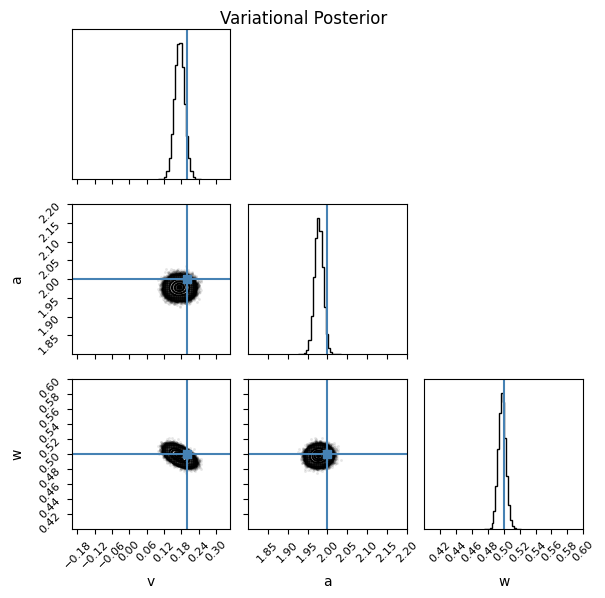

In [6]:
# Define your custom labels
labels = ['v', 'a', 'w']

# Define the true values for the parameters
true_values = [true_v, true_a, true_w]

# Define the axis limits for each parameter
x_limits = span  # Replace with actual limits

# Define the plot style with the custom labels, true values, and other parameters
plot_style = {
    'corner': {
        'labels': labels,
        'title_kwargs': {'fontsize': 10},   # Increase title font size
        'label_kwargs': {'fontsize': 10},   # Increase label font size
        'truths': true_values,              # Add the true values
        'max_n_ticks': 10,                  # Increase number of ticks to 10
        'tick_params': {'labelsize': 10},   # Increase tick size to 10
    }
}

# Call the plot method with the plot_style parameter
fig = vp.plot(
    n_samples=int(3e5),
    title="Variational Posterior",
    plot_style=plot_style,
)

# Adjust tick parameters and axis limits for each subplot
axes = np.array(fig.axes).reshape((3, 3))
for i, ax in enumerate(axes.flatten()):
    ax.tick_params(axis='both', which='major', labelsize=8)  # Set tick size
    if i % 4 == 0:  # Diagonal plots (1D marginal distributions)
        ax.set_xlim(x_limits[i // 4])
    else:  # Off-diagonal plots (2D marginal distributions)
        row, col = divmod(i, 3)
        ax.set_xlim(x_limits[col])
        ax.set_ylim(x_limits[row])

# Show or save the plot as needed
plt.show()  # or plt.savefig('cornerplot.png')
import os
os.makedirs(save_path, exist_ok=True)

filename = f"vbmc_{N_sim}_same_width.png"
full_path = os.path.join(save_path, filename)

# Save the figure
fig.savefig(full_path, dpi=300, bbox_inches='tight')
plt.close(fig)

# VBMC ELBO over iterations

In [32]:
N_trials_arr = [100, 500, 1000, 5000]
# 5000_elbo_dict.pkl
all_elbo_dict = {}
for n in N_trials_arr:
    all_elbo_dict[n] = pickle.load(open(f'{n}_elbo_dict.pkl', 'rb'))

Text(0, 0.5, 'ELBO')

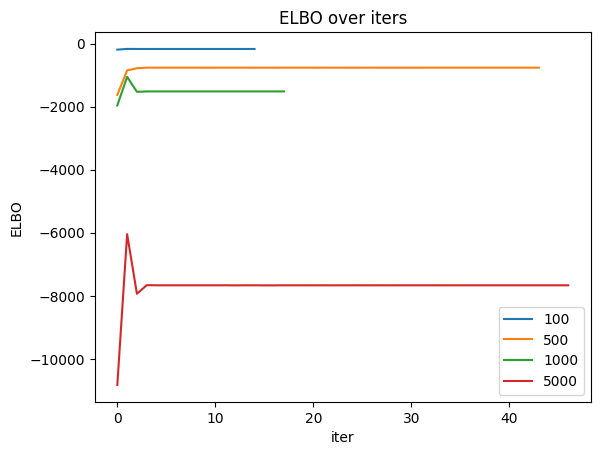

In [38]:
plt.plot(all_elbo_dict[100]['mean']);
plt.plot(all_elbo_dict[500]['mean']);
plt.plot(all_elbo_dict[1000]['mean']);
plt.plot(all_elbo_dict[5000]['mean']);
plt.legend(['100', '500', '1000', '5000']);
plt.title('ELBO over iters')
plt.xlabel('iter')
plt.ylabel('ELBO')

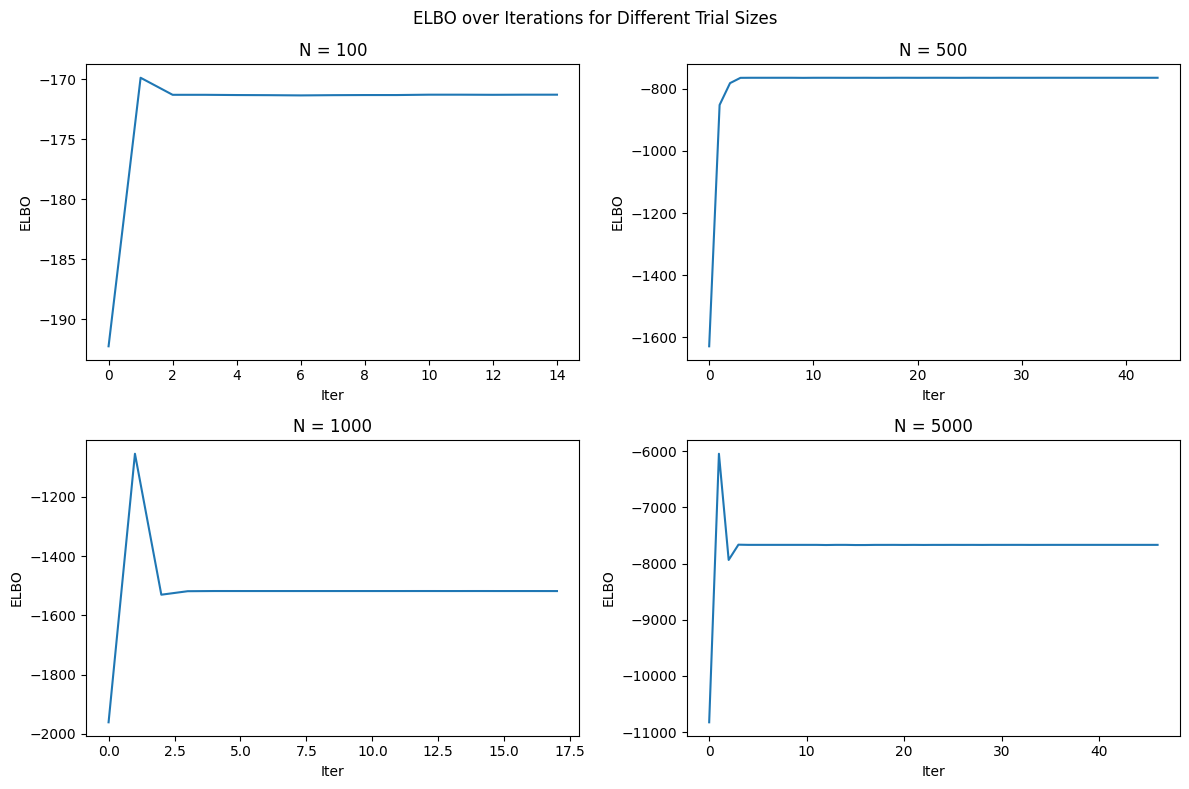

In [39]:

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot for trial size 100
axs[0, 0].plot(all_elbo_dict[100]['mean'])
axs[0, 0].set_title('N = 100')
axs[0, 0].set_xlabel('Iter')
axs[0, 0].set_ylabel('ELBO')

# Plot for trial size 500
axs[0, 1].plot(all_elbo_dict[500]['mean'])
axs[0, 1].set_title('N = 500')
axs[0, 1].set_xlabel('Iter')
axs[0, 1].set_ylabel('ELBO')

# Plot for trial size 1000
axs[1, 0].plot(all_elbo_dict[1000]['mean'])
axs[1, 0].set_title('N = 1000')
axs[1, 0].set_xlabel('Iter')
axs[1, 0].set_ylabel('ELBO')

# Plot for trial size 5000
axs[1, 1].plot(all_elbo_dict[5000]['mean'])
axs[1, 1].set_title('N = 5000')
axs[1, 1].set_xlabel('Iter')
axs[1, 1].set_ylabel('ELBO')

fig.suptitle('ELBO over Iterations for Different Trial Sizes')
plt.tight_layout()
plt.show()


# Scatter evidence vs ELBO

In [19]:
N_trials_arr = [100, 500, 1000, 5000]


# NS
all_evidence_dict = {}
for n in N_trials_arr:
    with open(f'ns_{n}_evidence.pkl', 'rb') as f:
        all_evidence_dict[n] = pickle.load(f)

# VBMC
all_elbo_dict = {}
for n in N_trials_arr:
    all_elbo_dict[n] = pickle.load(open(f'{n}_elbo_dict.pkl', 'rb'))

Text(0, 0.5, 'Evidence - ELBO')

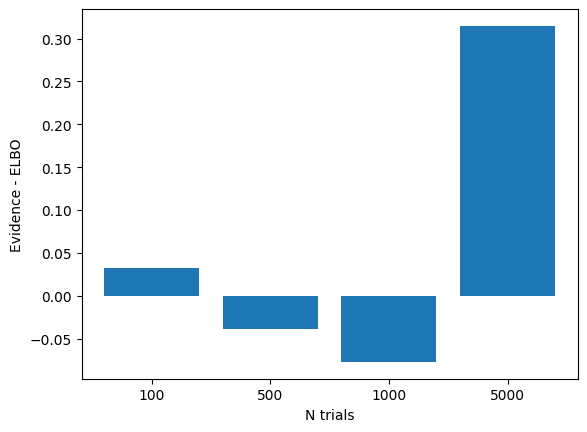

In [42]:
evid_elbo = [[-157.84878277307507,-157.881],[-787.7238567339078, -787.685], [-1570.5103274699588, -1570.433], [-7732.753137310123, -7733.068]]

evids = [e[0] for e in evid_elbo]
elbs = [e[1] for e in evid_elbo]
N_trials_arr = [100, 500, 1000, 5000]

plt.bar([str(n) for n in N_trials_arr], np.array(evids)-np.array(elbs))
plt.xlabel('N trials'); plt.ylabel('Evidence - ELBO')


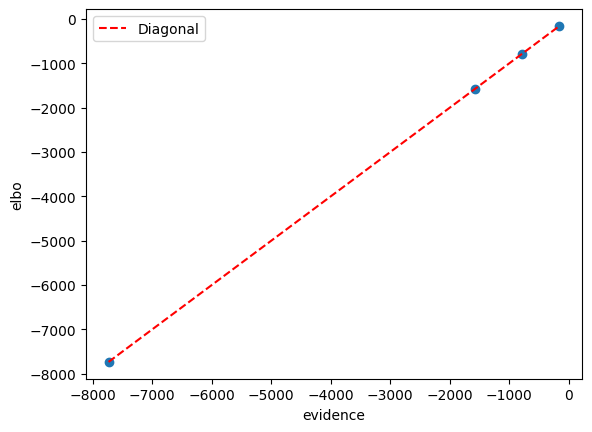

In [45]:
plt.plot(evids, elbs, 'o')
plt.xlabel('evidence')
plt.ylabel('elbo')
# Add a diagonal line
min_val = min(min(evids), min(elbs))
max_val = max(max(evids), max(elbs))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Diagonal')
plt.legend()

plt.show()

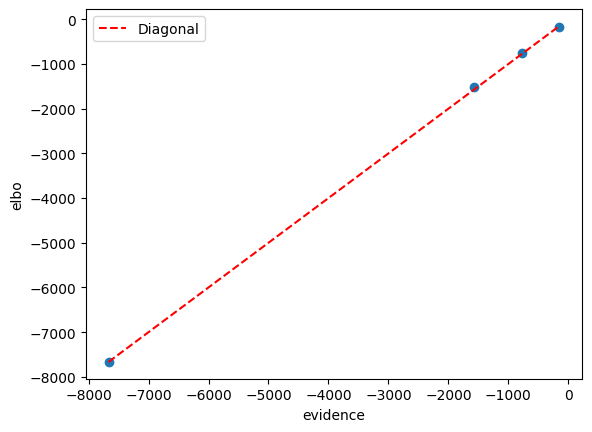

In [25]:
elbos = [all_elbo_dict[n]['mean'][-1] for n in N_trials_arr]
evids = [all_evidence_dict[n]['cum_evid'][-1] for n in N_trials_arr]


plt.plot(evids, elbos, 'o')
plt.xlabel('evidence')
plt.ylabel('elbo')
# Add a diagonal line
min_val = min(min(evids), min(elbos))
max_val = max(max(evids), max(elbos))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Diagonal')
plt.legend()

plt.show()

Text(0, 0.5, 'evidence - ELBO')

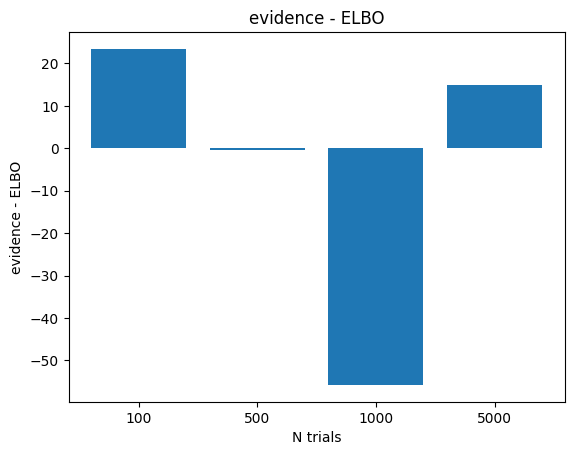

In [36]:
plt.bar(bar_x,np.array(evids)-np.array(elbos))
plt.title('evidence - ELBO')
plt.xlabel('N trials'); plt.ylabel('evidence - ELBO')

In [40]:
evids[-2],elbos[-2]

(-1573.6566586627498, -1517.87)

In [80]:
v_a_w, _ = vp.sample(int(3e5))
v_samp = v_a_w[:,0]; a_samp = v_a_w[:,1]; w_samp = v_a_w[:,2]

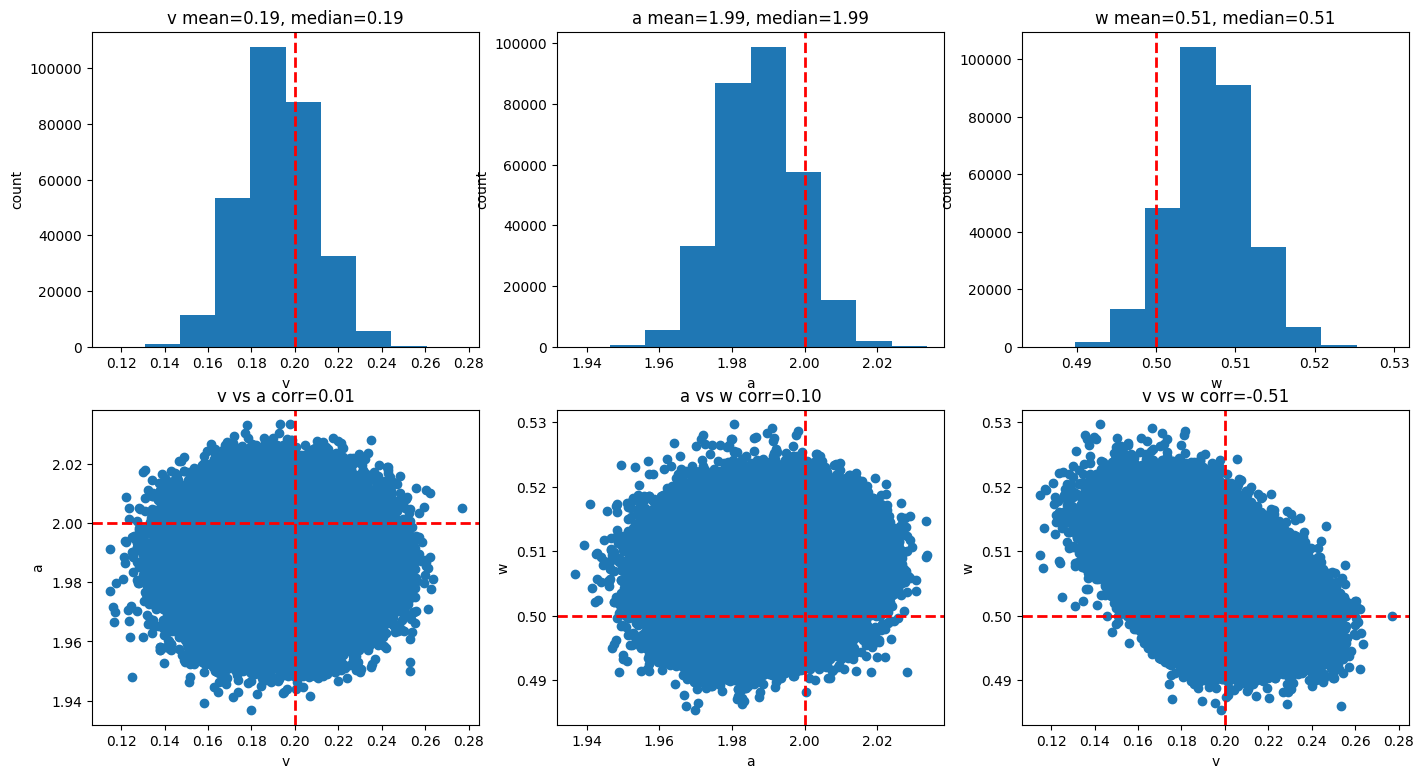

In [81]:
plt.figure(figsize=(17, 9))

plt.subplot(2, 3, 1)
plt.hist(v_samp)
plt.axvline(true_v, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('v')
plt.ylabel('count')
plt.title(f'v mean={np.mean(v_samp):.2f}, median={np.median(v_samp):.2f}')

# Histogram for a_samp
plt.subplot(2, 3, 2)
plt.hist(a_samp)
plt.axvline(true_a, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('a')
plt.ylabel('count')
plt.title(f'a mean={np.mean(a_samp):.2f}, median={np.median(a_samp):.2f}')

# Histogram for w_samp
plt.subplot(2, 3, 3)
plt.hist(w_samp)
plt.axvline(true_w, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('w')
plt.ylabel('count')
plt.title(f'w mean={np.mean(w_samp):.2f}, median={np.median(w_samp):.2f}')

# Scatter plot for v_samp vs a_samp
plt.subplot(2, 3, 4)
plt.scatter(v_samp, a_samp)
plt.axhline(true_a, color='red', linestyle='dashed', linewidth=2)
plt.axvline(true_v, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('v')
plt.ylabel('a')
plt.title(f'v vs a corr={np.corrcoef(v_samp, a_samp)[0, 1]:.2f}')

# Scatter plot for a_samp vs w_samp
plt.subplot(2, 3, 5)
plt.scatter(a_samp, w_samp)
plt.axhline(true_w, color='red', linestyle='dashed', linewidth=2)
plt.axvline(true_a, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('a')
plt.ylabel('w')
plt.title(f'a vs w corr={np.corrcoef(a_samp, w_samp)[0, 1]:.2f}')

# Scatter plot for v_samp vs w_samp
plt.subplot(2, 3, 6)
plt.scatter(v_samp, w_samp)
plt.axhline(true_w, color='red', linestyle='dashed', linewidth=2)
plt.axvline(true_v, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('v')
plt.ylabel('w')
plt.title(f'v vs w corr={np.corrcoef(v_samp, w_samp)[0, 1]:.2f}')

plt.show()